In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model  import Lasso
from sklearn.linear_model import ElasticNet



pd.set_option('display.max_columns',None)
pd.set_option("display.max_rows",None)
pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings('ignore')


import pickle

In [14]:
df = pd.read_excel('Veri-Seti.xlsx',index_col="Date",parse_dates=['Date'])
df.columns = df.columns.str.lower().str.replace(" ","_")
df = df.iloc[:149,:]

### Data Analysis & Cleaning

In [15]:
df.head()

,otv_orani,faiz,eur/tl,kredi_stok,otomotiv_satis
Date,,,,,
2010-01-01,37.00,13.18,2.11,"341,244.13","20,095.00"
2010-02-01,37.00,13.27,2.07,"351,940.95","31,172.00"
2010-03-01,37.00,12.73,2.09,"361,307.32","51,769.00"
2010-04-01,37.00,12.01,2.01,"373,575.34","54,946.00"
2010-05-01,37.00,11.74,1.95,"387,708.05","59,377.00"


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 149 entries, 2010-01-01 to 2022-05-01
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   otv_orani       149 non-null    float64
 1   faiz            149 non-null    float64
 2   eur/tl          149 non-null    float64
 3   kredi_stok      149 non-null    float64
 4   otomotiv_satis  149 non-null    float64
dtypes: float64(5)
memory usage: 7.0 KB


In [17]:
df.isnull().sum()

otv_orani         0
faiz              0
eur/tl            0
kredi_stok        0
otomotiv_satis    0
dtype: int64

In [18]:
df.describe()

,otv_orani,faiz,eur/tl,kredi_stok,otomotiv_satis
count,149.00,149.00,149.00,149.00,149.00
mean,43.70,16.03,4.81,"1,787,554.29","65,902.62"
std,5.85,5.32,3.32,"1,176,365.97","26,175.80"
min,37.00,9.61,1.93,"341,244.13","14,373.00"
25%,40.00,12.71,2.46,"775,545.50","50,008.00"
50%,45.00,14.48,3.28,"1,474,594.12","63,044.00"
75%,50.00,17.48,6.38,"2,447,479.19","79,819.00"
max,65.00,32.78,16.56,"4,862,887.42","156,173.00"


### Baseline Model

I will use Ridge regression in order to avoid multicollinearity

In [19]:
rr = Ridge(alpha=.1)

In [20]:
predictors = df.columns[~df.columns.isin(['otomotiv_satis'])]

In [21]:
predictors

Index(['otv_orani', 'faiz', 'eur/tl', 'kredi_stok'], dtype='object')

In [22]:
def backtest(df, model, predictors, start=120, step=6):
    """
    Parameters
    df : dataset
    predictors : features we want to use for prediction
    start : data that is used for training
    period : period that is used for prediction after training set
    """
    
    all_predictions = []
    
    for i in range(start, df.shape[0], step):
        train = df.iloc[:i,:]
        test = df.iloc[i:(i+step),:]
        
        model.fit(train[predictors], train["otomotiv_satis"])
        
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["otomotiv_satis"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [23]:
predictions = backtest(df,rr,predictors)

In [29]:
print("%",round(mean_absolute_percentage_error(predictions['actual'],predictions['prediction']),2)*100)

% 51.0


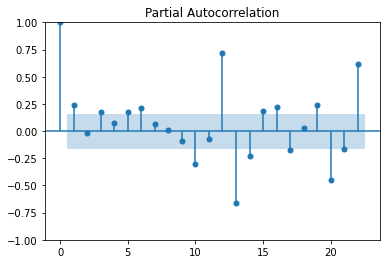

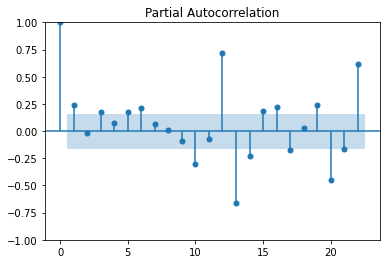

In [30]:
plot_pacf(df.otomotiv_satis)

### Feature Engineering

### Adding Window and Lag Features

In [31]:
def compute_rolling(df, horizon, col):
    label = f"rolling_{horizon}_{col}"
    df[label] = df[col].rolling(horizon).mean()
    return df

def compute_lagging(df, horizon, col):
    label = f"lagging_{horizon}_{col}"
    df[label] = df[col].shift(horizon)
    
    return df
lagging_horizons = [1]
for horizon in lagging_horizons:
    for col in ["otomotiv_satis"]:
        df = compute_lagging(df, horizon, col)
        
rolling_horizons = [3]
for horizon in rolling_horizons:
    for col in ["otomotiv_satis"]:
        df = compute_rolling(df, horizon, col)

### Adding Date Components

In [32]:
df['month'] = df.index.month
df['year'] = df.index.year
df['quarter'] = df.index.quarter

In [33]:
df.head()

,otv_orani,faiz,eur/tl,kredi_stok,otomotiv_satis,lagging_1_otomotiv_satis,rolling_3_otomotiv_satis,month,year,quarter
Date,,,,,,,,,,
2010-01-01,37.00,13.18,2.11,"341,244.13","20,095.00",NaN,NaN,1,2010,1
2010-02-01,37.00,13.27,2.07,"351,940.95","31,172.00","20,095.00",NaN,2,2010,1
2010-03-01,37.00,12.73,2.09,"361,307.32","51,769.00","31,172.00","34,345.33",3,2010,1
2010-04-01,37.00,12.01,2.01,"373,575.34","54,946.00","51,769.00","45,962.33",4,2010,2
2010-05-01,37.00,11.74,1.95,"387,708.05","59,377.00","54,946.00","55,364.00",5,2010,2


In [34]:
df = df.iloc[2:,:]

In [35]:
df.head()

,otv_orani,faiz,eur/tl,kredi_stok,otomotiv_satis,lagging_1_otomotiv_satis,rolling_3_otomotiv_satis,month,year,quarter
Date,,,,,,,,,,
2010-03-01,37.00,12.73,2.09,"361,307.32","51,769.00","31,172.00","34,345.33",3,2010,1
2010-04-01,37.00,12.01,2.01,"373,575.34","54,946.00","51,769.00","45,962.33",4,2010,2
2010-05-01,37.00,11.74,1.95,"387,708.05","59,377.00","54,946.00","55,364.00",5,2010,2
2010-06-01,37.00,11.75,1.93,"399,140.76","60,896.00","59,377.00","58,406.33",6,2010,2
2010-07-01,37.00,11.38,1.97,"413,343.45","61,345.00","60,896.00","60,539.33",7,2010,3


In [36]:
predictors = df.columns[~df.columns.isin(['otomotiv_satis','kredi_stok','eur/tl'])]

In [42]:
list(predictors)

['otv_orani',
 'faiz',
 'lagging_1_otomotiv_satis',
 'rolling_3_otomotiv_satis',
 'month',
 'year',
 'quarter']

In [37]:
predictions = backtest(df,rr,predictors)

In [40]:
print("%",round(mean_absolute_percentage_error(predictions['actual'],predictions['prediction']),3)*100)

% 18.7


### Saving Model

In [143]:
pickle.dump(rr, open('model.pkl', 'wb'))